# Generating new faces with Variational Autoencoders (VAE)
This script demonstrates the process of building and training a VAE using Keras to generate new faces. We shall be using the CelebFaces Attributes (CelebA) Dataset from Kaggle for training the VAE model. Some parts of the Markdown notes are extracted from [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) 

## Simple Autoencoder
I first built a simple Autoencoder. A simple Autoencoder consists of two neural networks - an Encoder and a Decoder. An Encoder is responsible for converting an image into a compact lower dimensional vector (or latent vector). This latent vector is a compressed representation of the image. The Encoder maps an input from the higher dimensional input space to the lower dimensional latent space, a concept that is similar to a CNN classifier. The outputs of the encoder are then fed into the Decoder. The Decoder is a different neural network that tries to reconstruct the image from the lower dimensional latent space to the higher dimensional output space. The Encoder and Decoder perform mappings that are exactly opposite to each other, as shown in the image.

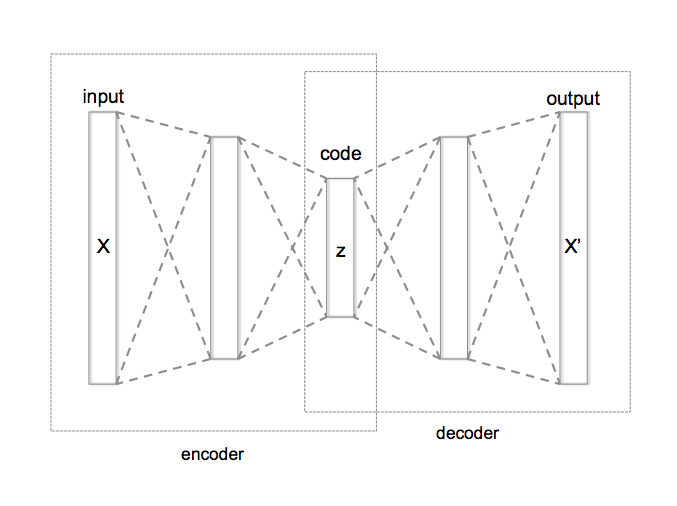

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from glob import glob

## Data preparation

I am not using Kera's flow_from_directory method because the function seems to hang on Kaggle. I took reference from Github the function of build_decoder to prepare the dataset for training. 

In [ ]:
WEIGHTS_FOLDER = '/kaggle/working/weights/'
DATA_FOLDER = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
Z_DIM = 200

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

In [ ]:
def build_decoder(test=False, out_size=(128, 128)):
    def decoder(path):
        img = file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels=3)  
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.float32) / 255.0
        return img
    def decoder_train(path):
        return decoder(path), decoder(path)

    return decoder if test else decoder_train

def build_dataset(paths, test=False, shuffle=1, batch_size=1):
    AUTO = tf.data.experimental.AUTOTUNE
    decoder = build_decoder(test)

    dset = tf.data.Dataset.from_tensor_slices(paths)
    dset = dset.map(decoder, num_parallel_calls=AUTO)
    
    dset = dset.shuffle(shuffle)
    dset = dset.batch(batch_size)
    return dset

In [ ]:
train_paths, valid_paths, _, _ = train_test_split(filenames, filenames, test_size=0.2, shuffle=True)

train_dataset = build_dataset(train_paths, batch_size=128)
valid_dataset = build_dataset(valid_paths, batch_size=128)

## Model Architecture - Autoencoder

The section covers the definition of the simple Autoencoder defined within a ConvAutoencoder Class.

In [ ]:
class ConvAutoencoder:
    def __init__(self):
        self.input_dim = (128,128,3)
        self.batch_size = 512
        self.latentDim = 200
        self.z_dim = 200 # Dimension of the latent vector (z)
        self.autoencoder_model = None
        self.encoder_model = None
        self.decoder_model = None

    #@staticmethod
    def build(self):
        inputs = Input(shape = self.input_dim)
        x = inputs
        
        filters=(32, 64, 64, 64)
        
        for index, f in enumerate(filters):
            x = Conv2D(f, (3,3), strides=2, padding="same", name="conv2dtranspose_" + str(index))(x)
            x = LeakyReLU()(x)
        
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(self.latentDim)(x)
        self.encoder_model = Model(inputs, latent, name = "encoder")
        
        latentInputs = Input(shape=(self.latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        for f in [64, 64, 32]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU()(x)

        x = Conv2DTranspose(3, (3, 3), strides=2, padding="same")(x)
        outputs = Activation("sigmoid")(x)
        self.decoder_model = Model(latentInputs, outputs, name="decoder")
        self.autoencoder_model = Model(inputs, self.decoder_model(self.encoder_model(inputs)),name="autoencoder")
        
        return None
    
    def get_encoder(self):
        if self.encoder_model is not None:
            return self.encoder_model
        else:
            print("Encoder model has not been defined!")
            return None

    def get_decoder(self):
        if self.decoder_model is not None:
            return self.decoder_model
        else:
            print("Decoder model has not been defined!")
            return None
    
    def get_autoencoder(self):
        if self.autoencoder_model is not None:
            return self.autoencoder_model
        else:
            print("Autoencoder model has not been defined!")
            return None

In [ ]:
model = ConvAutoencoder()
model.build()
encoder = model.get_encoder()
decoder = model.get_decoder()
autoencoder = model.get_autoencoder()
encoder.summary()
decoder.summary()
autoencoder.summary()

### Compilation and Training

Before the autoencoder is trained, it must be compiled. I compile the model with Adam optimiser with Root Mean Square Error (RMSE). I also compile the model with keras ModelCheckpoint to save the model weights for reuse. It saves 2 sets of model outputs - one output is the fresh set of weights after every epoch and one output is the best weights from all the epochs.

In [ ]:
LEARNING_RATE = 0.0005
N_EPOCHS = 20

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer=optimizer, loss = r_loss)

checkpoint_ae_best = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/autoencoder_best_weights.h5'), 
                                     monitor='val_loss',
                                     mode='min',
                                     save_best_only=True,
                                     save_weights_only = False, 
                                     verbose=1)

checkpoint_ae_last = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/autoencoder_last_weights.h5'), 
                                     monitor='val_loss',
                                     mode='min',
                                     save_best_only=True,
                                     save_weights_only = False, 
                                     verbose=1)

In [ ]:
autoencoder.fit(train_dataset,
                epochs=10,
                callbacks=[checkpoint_ae_best, checkpoint_ae_last],
                validation_data=valid_dataset)

## Decoding

The first image shows images directly from the dataset and the second images shows the outcomes after passing through Autoencoder. Evidently, the model has learned to encode and decode (reconstruct) but with observable degradation in quality.

In [ ]:
test_dataset = build_dataset(valid_paths, test=True)
autoencoder.load_weights('/kaggle/working/weights/AE/autoencoder_last_weights.h5')

In [ ]:
data = list(test_dataset.take(20))

fig = plt.figure(figsize=(30, 10))
for n in range(0, 20, 2):
    image = autoencoder.predict(data[n])
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(np.squeeze(data[n]))
    plt.title('original image')
    
    plt.subplot(2, 10, n + 2)
    plt.imshow(np.squeeze(image))
    plt.title('reconstruct')
    
plt.show()

## Autoencoder Decoding with noise

We can observe that the reconstructed images are becoming more distorted then noise is added to their encodings.

In [ ]:
data = list(test_dataset.take(20))

fig = plt.figure(figsize=(30, 10))
for n in range(0, 20, 2):
    image = encoder.predict(data[n])
    image += np.random.normal(0.0, 1.0, size = (Z_DIM)) #inject noise to the encoded vector
    reconst_images = decoder.predict(image)
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(np.squeeze(data[n]))
    plt.title('original image')
    
    plt.subplot(2, 10, n + 2)
    plt.imshow(np.squeeze(reconst_images))
    plt.title('Reconstruct noisy image')
    
plt.show()

## Limitations of autoencoders for content generation

Once the autoencoder network has been trained, we have both an encoder and a decoder but there is no real way to produce any new content. This is because a generation of meaningful content depends on the regularity of the output latent space by the encoder for the decoder to generate the new content. Pretty much, is to get the decoder to work more or less like the generator of a Generative Adversarial Network.

In a conventional autoencoder network, this regularity of the out latent space from the encoder is almost impossible. It depends on the distribution of the data in the initial space, the dimension of the latent space and the architecture of the encoder. There's no way that the encoder will organize the latent space in a smart way compatible with the generative process to produce new content 

## Variable Autoencoder

A variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process. A variational autoencoder is an architecture composed of both an encoder and a decoder and is trained to minimise the reconstruction error between the encoded-decoded data and the initial data. In addition, regularisation of the latent space is introduced within the process of encoding-decoding. This is done via a slight modification where instead of encoding an input as a single point, we encode it as a distribution over the latent space. The model is then trained as follows:
1. The input is encoded as distribution over the latent space
2. A point from the latent space is sampled from that distribution
3. The sampled point is decoded and the reconstruction error can be computed
4. The reconstruction error is backpropagated through the network

The loss function used is the sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if we use a loss factor too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

The section covers the definition of the Variable Autoencoder defined within a VariableAutoencoder Class.

In [ ]:
class VariableAutoencoder:
    def __init__(self):
        self.input_dim = (128,128,3)
        self.batch_size = 512
        self.z_dim = 200 # Dimension of the latent vector (z)
        self.learning_rate = 0.0005
        self.var_autoencoder_model = None
        self.var_encoder_model = None
        self.var_decoder_model = None

    def build(self):
        #Encoder
        input_encoder = Input(shape=(self.input_dim))
        x = Conv2D(32, kernel_size=(3, 3), strides = 2, padding='same', name='encoder_conv2d_1')(input_encoder)
        x = LeakyReLU()(x)
        x = Conv2D(64, kernel_size=(3, 3), strides = 2, padding='same', name='encoder_conv2d_2')(x)
        x = LeakyReLU()(x)
        x = Conv2D(64, kernel_size=(3, 3), strides = 2, padding='same', name='encoder_conv2d_3')(x)
        x = LeakyReLU()(x)
        x = Conv2D(64, kernel_size=(3, 3), strides = 2, padding='same', name='encoder_conv2d_4')(x)
        volumeSize = K.int_shape(x)
        x = Flatten()(x)

        latent_mu = Dense(self.z_dim, name='latent_mean')(x)
        latent_log_var = Dense(self.z_dim, name='latent_log_var')(x)
        
        def sampling(args=None):
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]

            epsilon = K.random_normal(shape=(batch, self.z_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
        latent_sample = Lambda(sampling)([latent_mu, latent_log_var])
        self.var_encoder_model = Model(input_encoder, latent_sample, name='encoder')

        latent_input = Input(shape=(self.z_dim,), name='decoder_input')
        x = Dense(np.prod(volumeSize[1:]))(latent_input)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        x = Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same', name='conv2d_1')(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same', name='conv2d_2')(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding='same', name='conv2d_3')(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(3, kernel_size=(3, 3), strides=2, padding='same', name='conv2d_4')(x)
        output_decoder = Activation('sigmoid')(x)

        self.var_decoder_model = Model(latent_input, output_decoder, name='decoder')

        output_vae = self.var_decoder_model(self.var_encoder_model(input_encoder))
        self.var_autoencoder_model = Model(input_encoder, output_vae, name ='variable_autoencoder')

        reconstruction_loss = binary_crossentropy(input_encoder, output_vae) * (128 * 128)
        reconstruction_loss = K.mean(reconstruction_loss)

        kl_loss = 1 + latent_log_var - K.square(latent_mu) - K.exp(latent_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        vae_loss = K.mean(reconstruction_loss + kl_loss)

        self.var_autoencoder_model.add_loss(vae_loss)  
        self.var_autoencoder_model.add_metric(reconstruction_loss, name='reconstruction_loss')
        self.var_autoencoder_model.add_metric(kl_loss, name='kl_divergence_loss')

        optimizer = Adam(lr = self.learning_rate)

        self.var_autoencoder_model.compile(optimizer=optimizer)

        return None

    def get_varencoder(self):
        if self.var_encoder_model is not None:
            return self.var_encoder_model
        else:
            print("Variable Encoder model has not been defined!")
            return None

    def get_vardecoder(self):
        if self.var_decoder_model is not None:
            return self.var_decoder_model
        else:
            print("Variable Decoder model has not been defined!")
            return None
    
    def get_varautoencoder(self):
        if self.var_autoencoder_model is not None:
            return self.var_autoencoder_model
        else:
            print("Variable Autoencoder model has not been defined!")
            return None    

In [ ]:
var_model = VariableAutoencoder()
var_model.build()

var_autoencoder = var_model.get_varautoencoder()
var_encoder = var_model.get_varencoder()
var_decoder = var_model.get_vardecoder()
var_autoencoder.summary()

In [ ]:
VAE_N_EPOCHS = 10

checkpoint_vae_best = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/vae_best_model.h5'), 
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only = True, 
                                      verbose=1)
    
checkpoint_vae_last = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/vae_last_model.h5'),
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_best_only=False,
                                      save_weights_only=True)

var_autoencoder.fit(train_dataset,
                    epochs=VAE_N_EPOCHS,
                    callbacks=[checkpoint_vae_best, checkpoint_vae_last],
                    validation_data=valid_dataset)

## Decoding by Variable Autoencoder

Likewise, the first image shows images directly from the dataset and the second images shows the outcomes after passing through the trained Variable Autoencoder. Evidently, the model is still able to encode and decode with observable degradation in quality.

In [ ]:
test_dataset = build_dataset(valid_paths, test=True)
var_autoencoder.load_weights(os.path.join(WEIGHTS_FOLDER, 'VAE/vae_last_model.h5'))

In [ ]:
data = list(test_dataset.take(20))

fig = plt.figure(figsize=(30, 10))
for n in range(0, 20, 2):
    image = var_autoencoder.predict(data[n])
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(np.squeeze(data[n]))
    plt.title('original image')
    
    plt.subplot(2, 10, n + 2)
    plt.imshow(np.squeeze(image))
    plt.title('reconstruct')
    
plt.show()

## Generate new faces using the Variable Autoencoder 

The Variable Autoencoder is capable enough of producing new faces from vectors samped from a standard normal distribution - although the output of the generated faces are not as good quality.

In [ ]:
def vae_generate_images(new_to_show=10):
    random_codes = np.random.normal(size=(new_to_show, 200))
    new_faces = var_decoder.predict(np.array(random_codes))

    fig = plt.figure(figsize=(30, 15))

    for i in range(new_to_show):
        ax = fig.add_subplot(6, 10, i+1)
        ax.imshow(new_faces[i])
        ax.axis('off')
    plt.show()

In [ ]:
vae_generate_images(30)